# Project Overview

## Import Libraries

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

## Business Case/Problem

## Data Description

## Data Load

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.

## Data Cleaning

Let's review columns to see which ones make the most sense to keep.

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
def filter_columns(df):
    columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode'
                  ]
    return df[columns_to_keep]

In [7]:
df_filtered = filter_columns(df)

In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   condition    21597 non-null  int64  
 7   grade        21597 non-null  int64  
 8   sqft_above   21597 non-null  int64  
 9   yr_built     21597 non-null  int64  
 10  zipcode      21597 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.8 MB


In [89]:
df_filtered.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,3.409825,7.657915,1788.596842
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.650546,1.173200,827.759761
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,370.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,3.000000,7.000000,1190.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,3.000000,7.000000,1560.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,4.000000,8.000000,2210.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,5.000000,13.000000,9410.000000


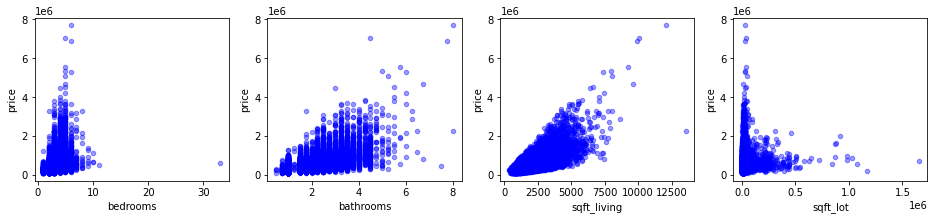

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 
                     'bathrooms',
                     'sqft_living',
                     'sqft_lot', 
                     ], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

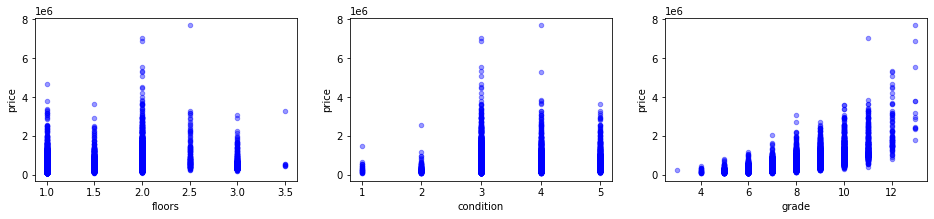

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'condition',
                     'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

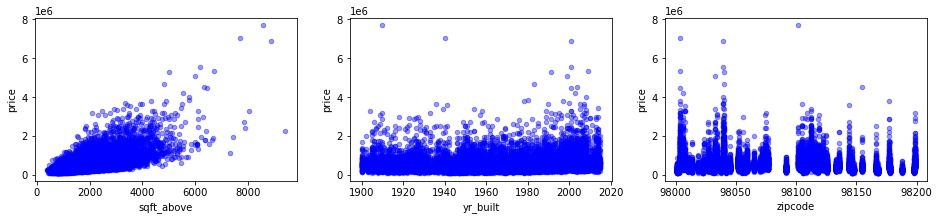

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

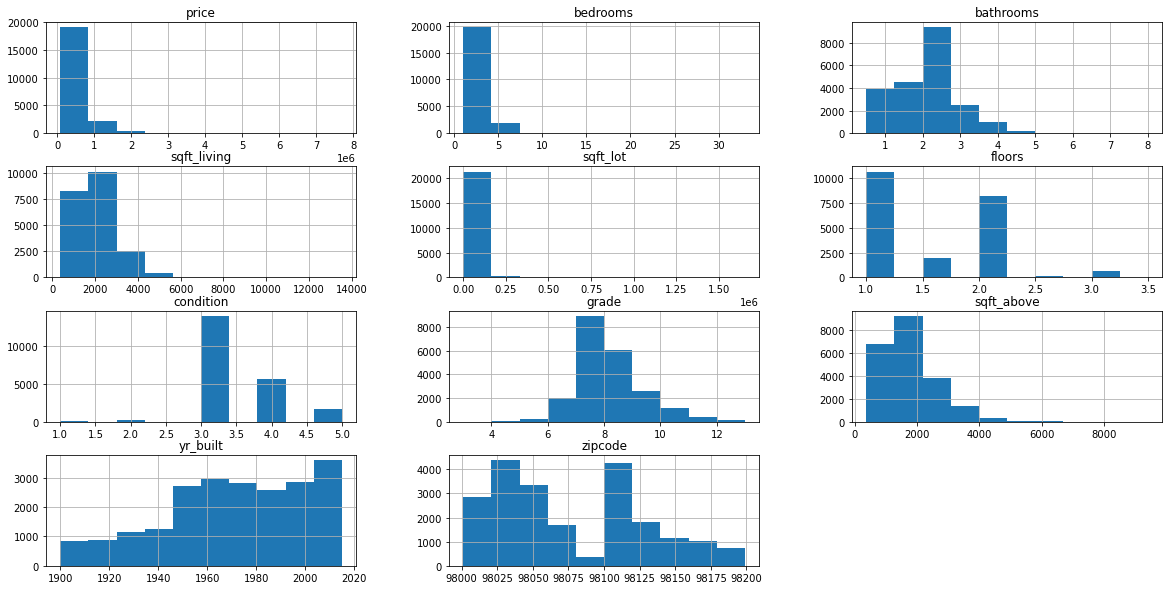

In [12]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_filtered.hist(ax = ax);

## Check for Multicollinearity

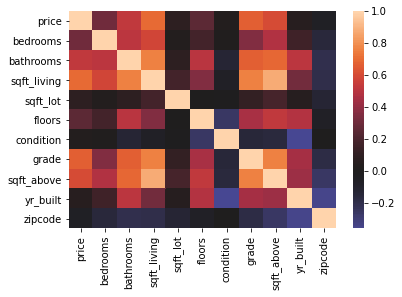

In [13]:
sns.heatmap(df_filtered.corr(), center=0);

# Model A (Simple Model)

## Feature Engineering

In [15]:
price = df_filtered['price']
bedrooms = df_filtered['bedrooms']
bathrooms = df_filtered['bathrooms']
sqft_living = df_filtered['sqft_living']
grade = df_filtered['grade']

In [16]:
simple_model_ols = pd.concat([price, bedrooms, bathrooms, sqft_living, grade], axis=1)
simple_model_ols.head()

,price,bedrooms,bathrooms,sqft_living,grade
0,221900.0,3,1.00,1180,7
1,538000.0,3,2.25,2570,7
2,180000.0,2,1.00,770,6
3,604000.0,4,3.00,1960,7
4,510000.0,3,2.00,1680,8


## Split Data into Training and Test set

In [35]:
target = simple_model_ols['price']
features = simple_model_ols.drop(['price'], axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features,target,test_size=0.2,random_state=42)
y_train_a

6243     332500.0
8986     390000.0
9419     800000.0
10155    462000.0
10436    695000.0
           ...   
11964    440000.0
21575    572000.0
5390     299800.0
860      245000.0
15795    545000.0
Name: price, Length: 17277, dtype: float64

## Model A Training

In [41]:
outcome = 'y_train_a'
predictors = X_train_a
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [42]:
data_a = pd.concat([X_train_a,y_train_a], axis=1)
data_a.head()

,bedrooms,bathrooms,sqft_living,grade,price
6243,4,2.00,1440,7,332500.0
8986,3,1.75,1430,7,390000.0
9419,4,2.75,3120,9,800000.0
10155,4,2.50,2060,7,462000.0
10436,3,2.00,2500,7,695000.0


In [43]:
model_a_ols = ols(formula=formula, data=data_a).fit()
model_a_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_a   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5184.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:06:52   Log-Likelihood:            -2.3917e+05
No. Observations:               17277   AIC:                         4.783e+05
Df Residuals:                   17272   BIC:                         4.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.87e+05    1.7e+04    -28.689      0.000    -5.2e+05   -4.54e+05
bedrooms    -4.335e+04   2685.131    -16.143      0.000   -4.86e+04   -3.81e+04
bathrooms   -2.448e+04   3936.106     -6.219      0.000   -3.22e+04   -1.68e+04
sqft_living   227.8517      4.065     56.054      0.000     219.884     235.819
grade        9.819e+04   2607.614     37.654      0.000    9.31e+04    1.03e+05
==============================================================================
Omnibus:                    12674.639   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           584848.422
Skew:                           3.045   Prob(JB):                         0.00
Kurtosis:                      30.845   Cond. No.                     2.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
simple_model = LinearRegression()
simple_model.fit(X_train_a,y_train_a)

LinearRegression()

In [50]:
simple_model.coef_

array([-43346.87097738, -24480.19836325,    227.8517448 ,  98187.07710573])

In [51]:
simple_model.intercept_

-487046.2750142581

In [61]:
yhat = simple_model.predict(X_test_a)
print(yhat)

[147349.40899645 291611.51097431 379649.95769289 ... 417614.21209066
 462447.12803966 340199.6583235 ]


In [75]:
resid = yhat - y_test_a
resid

3686      14849.408996
10247   -123388.489026
4037    -114350.042307
3437     -18399.785701
19291   -218479.929368
             ...      
2522      48311.026999
11119    179355.309833
11973    -19385.787909
17601    169447.128040
19844     46732.658323
Name: price, Length: 4320, dtype: float64

## Model A Evaluation

ValueError: x and y must be the same size

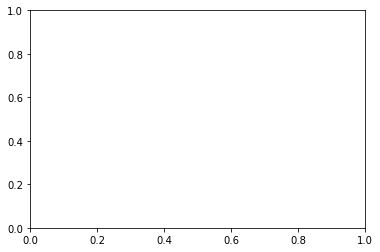

In [76]:
plt.scatter(X_test_a, y_test_a)
sns.lineplot(x=X_test_a, y=yhat,color='red');

In [102]:
print(X_test_a)

       bedrooms  bathrooms  sqft_living  grade
3686          3       0.75          850      6
10247         3       1.00         1510      6
4037          4       2.25         1790      7
3437          2       1.50         1140      7
19291         3       1.00         1500      7
...         ...        ...          ...    ...
2522          2       1.00         1020      6
11119         3       2.50         2050      8
11973         5       2.00         2120      7
17601         3       2.50         1990      7
19844         4       2.00         1590      7

[4320 rows x 4 columns]


In [106]:
print(yhat)

[147349.40899645 291611.51097431 379649.95769289 ... 417614.21209066
 462447.12803966 340199.6583235 ]


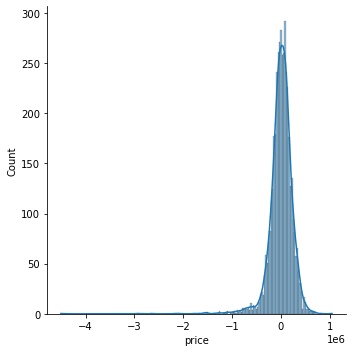

In [65]:
sns.displot(x=resid,kind='hist',kde=True);

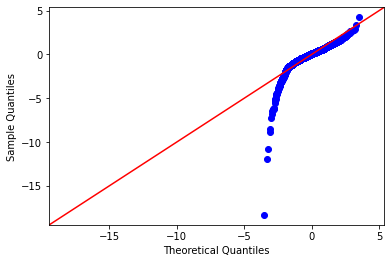

In [68]:
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45',fit=True)

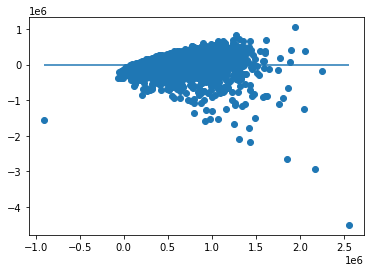

In [70]:
plt.scatter(yhat, resid)
plt.hlines(y=0, xmin=yhat.min(), xmax=yhat.max())

Text(0.5, 1.0, 'Actual vs. Predicted')

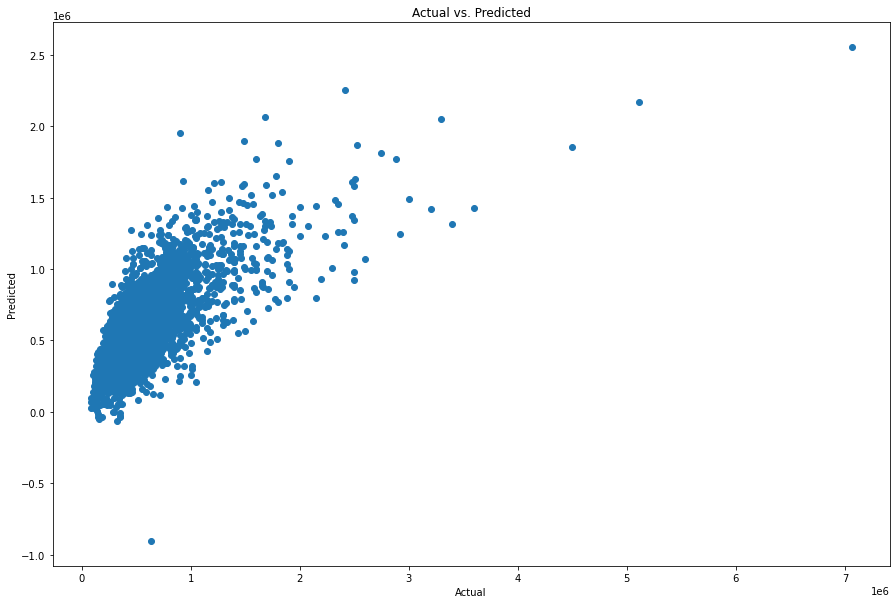

In [63]:
plt.figure(figsize=(15,10))
plt.scatter(y_test_a, yhat)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

## Cross Validation

In [73]:
model_a_scores = cross_val_score(simple_model, X_test_a, y_test_a, cv=5)
model_a_scores

array([0.52194145, 0.50012173, 0.55545965, 0.50878098, 0.56754696])

In [74]:
model_a_scores.mean(), model_a_scores.std()

(0.5307701563961759, 0.026316914174252436)

# Model B

## Create Dummy Variables

In [77]:
df_filtered['yr_built'] = df_filtered['yr_built'].astype('str')
df_filtered['zipcode'] = df_filtered['zipcode'].astype('str')
df_filtered['floors'] = df_filtered['floors'].astype('str')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  object 
 6   condition    21597 non-null  int64  
 7   grade        21597 non-null  int64  
 8   sqft_above   21597 non-null  int64  
 9   yr_built     21597 non-null  object 
 10  zipcode      21597 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [78]:
zip_dummies = pd.get_dummies(df_filtered['zipcode'], prefix='zip', drop_first=True)
yr_dummies = pd.get_dummies(df_filtered['yr_built'], prefix='yr', drop_first=True)
floor_dummies = pd.get_dummies(df_filtered['floors'], prefix='flr', drop_first=True)

In [79]:
df_dummies = df_filtered.drop(['zipcode','yr_built','floors'], axis=1)

In [80]:
df_dummies = pd.concat([df_filtered, zip_dummies, yr_dummies, floor_dummies], axis=1)
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,...,0,0,0,0,0,0,1,0,0,0
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,...,0,0,0,0,0,0,0,0,0,0


## Remove Outliers

In [88]:
df_dummies.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above,zip_98002,zip_98003,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,3.409825,7.657915,1788.596842,0.009214,0.012965,...,0.006019,0.007871,0.009307,0.025883,0.00176,0.088438,0.381303,0.007455,0.028291,0.000324
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.650546,1.173200,827.759761,0.095550,0.113125,...,0.077352,0.088373,0.096024,0.158791,0.04191,0.283938,0.485718,0.086020,0.165807,0.018001
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,370.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,3.000000,7.000000,1190.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,3.000000,7.000000,1560.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,4.000000,8.000000,2210.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,5.000000,13.000000,9410.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


## Log Transformations

In [82]:
logsqft = np.log(df_filtered['sqft_living'])

## Feature Scaling

In [83]:
scaled_sqft = (logsqft-np.mean(logsqft))/np.sqrt(np.var(logsqft))

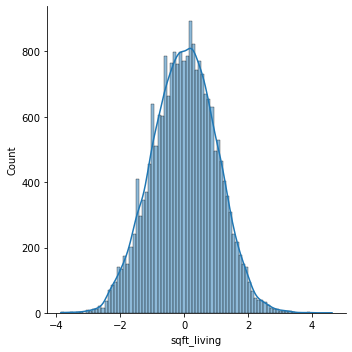

In [85]:
sns.displot(x=scaled_sqft,kind='hist',kde=True);

## Model B Training

In [ ]:
price = df_dummies['price']
bedrooms = df_dummies['bedrooms']
bathrooms = df_dummies['bathrooms']
scaled_sqft
zip_dummies
yr_dummies

In [84]:
model_b = pd.concat([price, bedrooms, bathrooms, scaled_sqft, zip_dummies, yr_dummies], axis=1)
model_b.head()

,price,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
0,221900.0,3,1.00,-1.125582,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,0.709463,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,-2.131943,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,0.070676,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,-0.292732,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split Data into Training and Test Set

In [99]:
target = model_b['price']
features = model_b.drop(['price'], axis=1)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(features,target,test_size=0.2,random_state=42)
X_train_b.head()

,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
6243,4,2.00,-0.656140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8986,3,1.75,-0.672568,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9419,4,2.75,1.166643,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10155,4,2.50,0.187988,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10436,3,2.00,0.644360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
outcome = 'y_train_b'
predictors = X_train_b
pred_sum = '+'.join(predictors.columns)
formula_b = outcome + '~' + pred_sum

In [97]:
data_b = pd.concat([X_train_b,y_train_b], axis=1)
data_b.head()

,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,price
6243,4,2.00,-0.656140,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,332500.0
8986,3,1.75,-0.672568,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,390000.0
9419,4,2.75,1.166643,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,800000.0
10155,4,2.50,0.187988,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,462000.0
10436,3,2.00,0.644360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,695000.0


In [101]:
model_b_ols = ols(formula=formula_b, data=data_b).fit()
model_b_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_train_b   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     189.6
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:00:07   Log-Likelihood:            -2.3627e+05
No. Observations:               17277   AIC:                         4.729e+05
Df Residuals:                   17089   BIC:                         4.744e+05
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.618e+05   3.03e+04     11.936      0.000    3.02e+05    4.21e+05
bedrooms    -4.467e+04   2444.759    -18.274      0.000   -4.95e+04   -3.99e+04
bathrooms    9.193e+04   3819.465     24.068      0.000    8.44e+04    9.94e+04
sqft_living  1.833e+05   2947.122     62.196      0.000    1.78e+05    1.89e+05
zip_98002    1.586e+04   2.15e+04      0.739      0.460   -2.62e+04    5.79e+04
zip_98003    2.188e+04   1.91e+04      1.146      0.252   -1.55e+04    5.93e+04
zip_98004    8.388e+05   1.87e+04     44.938      0.000    8.02e+05    8.75e+05
zip_98005    3.824e+05   2.23e+04     17.142      0.000    3.39e+05    4.26e+05
zip_98006     3.78e+05   1.68e+04     22.534      0.000    3.45e+05    4.11e+05
zip_98007    2.855e+05   2.38e+04     12.016      0.000    2.39e+05    3.32e+05
zip_98008    3.343e+05   1.91e+04     17.512      0.000    2.97e+05    3.72e+05
zip_98010    1.173e+05   2.64e+04      4.439      0.000    6.55e+04    1.69e+05
zip_98011    1.253e+05   2.13e+04      5.872      0.000    8.35e+04    1.67e+05
zip_98014    1.317e+05   2.42e+04      5.449      0.000    8.43e+04    1.79e+05
zip_98019    7.375e+04   2.15e+04      3.430      0.001    3.16e+04    1.16e+05
zip_98022    4.819e+04   2.01e+04      2.392      0.017    8700.645    8.77e+04
zip_98023    5329.6354   1.65e+04      0.324      0.746   -2.69e+04    3.76e+04
zip_98024    2.161e+05   2.84e+04      7.611      0.000     1.6e+05    2.72e+05
zip_98027     2.06e+05   1.71e+04     12.048      0.000    1.72e+05     2.4e+05
zip_98028    1.233e+05    1.9e+04      6.492      0.000    8.61e+04    1.61e+05
zip_98029    2.293e+05   1.85e+04     12.370      0.000    1.93e+05    2.66e+05
zip_98030     404.5698   1.97e+04      0.021      0.984   -3.82e+04     3.9e+04
zip_98031    1.157e+04    1.9e+04      0.607      0.544   -2.58e+04    4.89e+04
zip_98032    3.323e+04   2.48e+04      1.341      0.180   -1.53e+04    8.18e+04
zip_98033    4.154e+05   1.72e+04     24.159      0.000    3.82e+05    4.49e+05
zip_98034    2.313e+05   1.62e+04     14.307      0.000       2e+05    2.63e+05
zip_98038     1.82e+04   1.61e+04      1.128      0.260   -1.34e+04    4.98e+04
zip_98039    1.576e+06   3.46e+04     45.520      0.000    1.51e+06    1.64e+06
zip_98040    6.862e+05   1.92e+04     35.761      0.000    6.49e+05    7.24e+05
zip_98042    2.603e+04   1.63e+04      1.601      0.109   -5843.885    5.79e+04
zip_98045    1.337e+05      2e+04      6.680      0.000    9.45e+04    1.73e+05
zip_98052    2.597e+05   1.61e+04     16.125      0.000    2.28e+05    2.91e+05
zip_98053    2.493e+05   1.76e+04     14.149      0.000    2.15e+05    2.84e+05
zip_98055    4.174e+04    1.9e+04      2.195      0.028    4474.820     7.9e+04
zip_98056    1.207e+05   1.73e+04      6.968      0.000    8.68e+04    1.55e+05
zip_98058    5.352e+04    1.7e+04      3.15

## Evaluate

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

## Model C

In [ ]:
updated_zip = zip_dummies.drop(['zip_98002','zip_98003','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042',
                 'zip_98092','zip_98188'], axis=1)
updated_zip

In [ ]:
updated_yr = yr_dummies.drop([])

## Model D

## Feature Engineering

## Model Training

## Model Evaluation

## Conclusions/Summary